# Test the new omega model for oblique flames

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from os.path import join
import dask.dataframe as dd

In [2]:
# import a database
path_to_data = '/home/max/HDD3_DNS/Planar/NX512/UPRIME5/postProcess_DNN'

print(os.listdir(path_to_data))

['small_testset_1.parquet', 'filter_width_12_DNN_UPRIME5_test.parquet', 'small_testset_2.parquet', 'slice_plane_z_16_DNN_UPRIME5.parquet', 'TRAIN', 'filter_width_16_DNN_UPRIME5_test.parquet', 'data_explore.ipynb', 'filter_width_8_DNN_UPRIME5_test.parquet', 'Berechnung der Winkel 2D.ipynb', 'filter_width_24_DNN_UPRIME5_train.parquet', 'moments_UPRIME5_Log.csv', 'filter_width_32_DNN_UPRIME5_train.parquet', 'small_testset.parquet', 'filter_width_16_DNN_UPRIME5_train.parquet', 'filter_width_28_DNN_UPRIME5_test.parquet', '.ipynb_checkpoints', 'KEEP_OUT', 'slice_plane_x_20_DNN_UPRIME5.parquet', 'filter_width_8_DNN_UPRIME5_train.parquet', 'filter_width_20_DNN_UPRIME5_train.parquet', 'filter_width_20_DNN_UPRIME5_test.parquet', 'filter_width_4_DNN_UPRIME5_train.parquet', 'slice_plane_x_16_DNN_UPRIME5.parquet', 'slice_plane_y_20_DNN_UPRIME5.parquet', 'filter_width_4_DNN_UPRIME5_test.parquet', 'slice_plane_y_16_DNN_UPRIME5.parquet', 'filter_width_12_DNN_UPRIME5_train.parquet', 'filter_width_32_DN

In [3]:

FILTER_WITH_n = 24

data_pd= pd.read_parquet(join(path_to_data,'filter_width_%i_DNN_UPRIME5_train.parquet' % FILTER_WITH_n)).sample(frac=0.1)

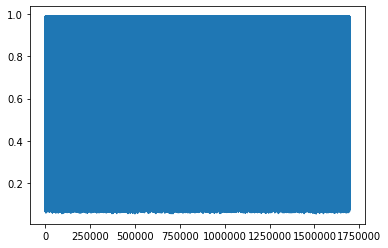

In [18]:
data_dd = dd.from_pandas(data_pd,npartitions=1)

data_dd['test'] = pd.Series(data_pd['c_bar'].values)

plt.plot(data_dd['test'].compute())#,data_dd['c_bar'].compute())

In [22]:
data_pd.head()

,c_bar,c_tilde,omega_DNS_filtered,omega_model_planar,mag_grad_U,mag_grad_c,mag_grad_c_tilde,norm_c_tilde_x,norm_c_tilde_y,norm_c_tilde_z,theta,phi,lambda_1,lambda_3,UP_delta,SGS_flux,c_prime,Delta_LES,filter_width
65170283,0.356555,0.266666,0.151224,0.226006,0.006432,0.001131,0.000719,-0.149711,-0.450030,-0.880375,2.647448,-1.249645,0.000029,1.033110e-07,0.606464,0.279314,0.072474,3.818183,24.0
34841983,0.961358,0.951069,0.200970,0.240487,0.011806,0.000600,0.000872,-0.062439,-0.163738,0.984526,0.176149,-1.206478,0.000053,8.195116e-10,1.275742,0.109252,0.008902,3.818182,24.0
31397338,0.782235,0.653971,0.284435,0.261835,0.007909,0.001459,0.002256,-0.456380,-0.887792,-0.059518,1.630350,-1.095963,0.000040,1.652602e-07,0.839011,0.222564,0.080998,3.818182,24.0
70548023,0.967364,0.953852,0.145655,0.232853,0.005524,0.000409,0.000640,-0.601123,0.600688,0.527092,1.015622,0.785036,0.000003,4.752613e-09,0.616124,0.038309,0.009950,3.818182,24.0
63876266,0.873320,0.815919,0.297987,0.261142,0.006382,0.000764,0.001075,-0.594962,-0.736349,-0.322196,1.898845,-0.891203,0.000035,1.393367e-07,0.934750,0.177675,0.041504,3.818183,24.0


In [18]:
# load the data base for interpolation

path_omega_interpolation = '/home/max/Python/DNS_Data_Klein/omega_interploation_database'

c_grid = np.load(join(path_omega_interpolation,'c_grid.npy'))
omega_array = np.load(join(path_omega_interpolation,'omega_array.npy'))
delta_xi_grid = np.load(join(path_omega_interpolation,'delta_xi_grid.npy'))

$\Delta_{\xi} = n \cdot d_{\xi,DNS}$ <br>
with $d_{\xi,DNS} = d_{th,xi}/11.14$ and $d_{th,xi}=1.79$ <br>
--> only for UPRIME5

In [19]:
# interpolate for best c_bar and delta_xi

delta_xi = FILTER_WITH_n * 1.792 / 11.14

c_bar_vec = data_pd['c_bar'].values
delta_xi_vec = np.ones(len(c_bar_vec)) * delta_xi


def interpolate_omega(c_bar,delta):
    
    omega_interpolated = c_bar.copy() * 0.0
    # loop over c_bar values
    for idx, c in enumerate(c_bar):
        index_c = np.argmin(np.abs(c_grid - c))
        index_delta = np.argmin(np.abs(delta_xi_grid - delta[idx]))
        
        omega_interpolated[idx] = omega_array[index_delta,index_c]
    
    return omega_interpolated


In [20]:
#%%timeit

omega_interpolated = interpolate_omega(c_bar_vec,delta_xi_vec)


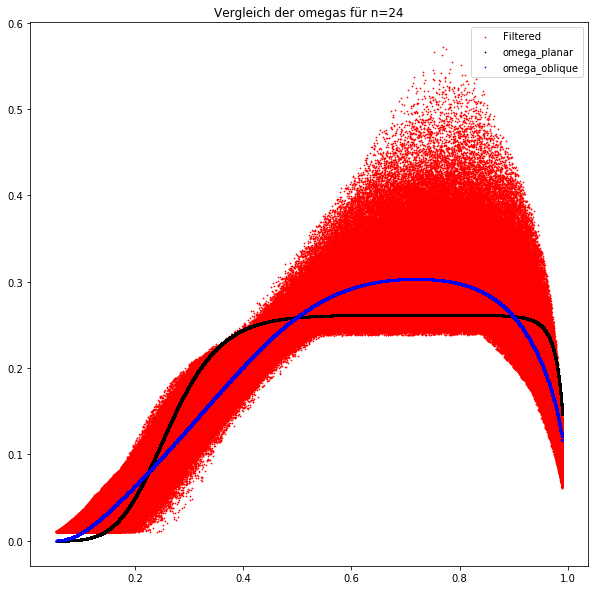

In [21]:
plt.figure(figsize=(10,10))
plt.title('Vergleich der omegas für n=%i' % FILTER_WITH_n)
plt.scatter(c_bar_vec,data_pd['omega_DNS_filtered'].values,s=0.5,c='r')
plt.scatter(c_bar_vec,data_pd['omega_model_planar'].values,s=0.5,c='k')
plt.scatter(c_bar_vec,omega_interpolated,s=0.5,c='b')
plt.legend(['Filtered','omega_planar','omega_oblique'])